# Menginstal Semua Library Yang Dibutuhkan

In [ ]:
!pip install numpy pandas scikit-learn opencv-python matplotlib scikit-image


# Memastikan file dataset emnist-letters-train.csv sudah ada di working directory

In [4]:
import os
print("Working dir:", os.getcwd())
print("Files here:", os.listdir()[:20])  # tampil sebagian file di folder kerja


Working dir: C:\Users\HP\EMNIST_Project
Files here: ['.ipynb_checkpoints', '4212301029_ATS.ipynb', 'loocv_checkpoint.joblib', 'X_hog.npy', 'y.npy']


# Membaca Dataset EMNIST Letters

In [14]:
import pandas as pd
import numpy as np

# ganti path jika file tidak ada di folder kerja
csv_path = "emnist-letters-train.csv"  

data = pd.read_csv(csv_path)
print("Jumlah baris total:", len(data))
print("Kolom:", data.shape[1])
# tampil 1 baris untuk cek
display(data.iloc[:2, :10])


Jumlah baris total: 88799
Kolom: 785


,23,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8
0,7,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0


# Sampling data sebanyak 13.000 sampel

In [15]:
# Jika ingin sampling penuh 13k:
sample_each = 500   # 500 per kelas => total 26*500 = 13k
sampled_data = []

for label in range(1, 27):   # label 1..26
    subset = data[data.iloc[:,0] == label]
    if len(subset) < sample_each:
        raise ValueError(f"Kelas {label} hanya punya {len(subset)} sample < {sample_each}")
    sampled_data.append(subset.sample(n=sample_each, random_state=42))

sampled_data = pd.concat(sampled_data).sample(frac=1, random_state=42).reset_index(drop=True)
print("Jumlah setelah sampling:", len(sampled_data))


Jumlah setelah sampling: 13000


# Perbaikan Orientasi Citra EMNIST

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

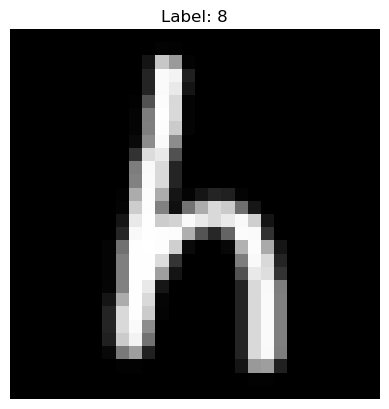

In [16]:
# Pisahkan fitur dan label dari sampled_data
y = sampled_data.iloc[:, 0].values            # label 1..26
X_pixels = sampled_data.iloc[:, 1:].values    # bentuk (N, 784)

# Ubah setiap gambar ke bentuk 28x28 dan perbaiki orientasi EMNIST
def fix_emnist_orientation(flat_img):
    img = flat_img.reshape(28, 28).astype(np.uint8)
    img = np.flip(img, axis=0)     # flip vertikal
    img = np.transpose(img)        # transpose
    img = np.flip(img, axis=1)     # flip horizontal
    return img

# contoh cek satu gambar
example = fix_emnist_orientation(X_pixels[0])
import matplotlib.pyplot as plt
plt.imshow(example, cmap='gray'); plt.title(f"Label: {y[0]}"); plt.axis('off')


# Ekstraksi Fitur HOG

In [17]:
from skimage.feature import hog
from tqdm import tqdm

def extract_hog_features_from_pixels(X_pixels):
    hog_list = []
    for flat in tqdm(X_pixels, desc="Ekstraksi HOG"):
        img = fix_emnist_orientation(flat)
        feat = hog(img,
                   orientations=9,
                   pixels_per_cell=(8,8),
                   cells_per_block=(2,2),
                   block_norm='L2-Hys')
        hog_list.append(feat)
    return np.array(hog_list)

# Ekstraksi HOG (akan memakan waktu tergantung jumlah sampel)
X_hog = extract_hog_features_from_pixels(X_pixels)
print("X_hog shape:", X_hog.shape)


Ekstraksi HOG: 100%|██████████████████████████████████████████████████████████| 13000/13000 [00:02<00:00, 5885.48it/s]

X_hog shape: (13000, 144)


# Menyimpan Fitur HOG

In [23]:
np.save("X_hog.npy", X_hog)
np.save("y.npy", y)
print("Tersimpan X_hog.npy dan y.npy")


Tersimpan X_hog.npy dan y.npy


# Meload Fitur HOG

In [3]:
import os
import numpy as np

if os.path.exists("X_hog.npy") and os.path.exists("y.npy"):
    X_hog = np.load("X_hog.npy")
    y = np.load("y.npy")
    print("Loaded X_hog and y from disk:", X_hog.shape, y.shape)
else:
    print("File X_hog.npy / y.npy tidak ditemukan. Pastikan kamu sudah menjalankan ekstraksi HOG.")


Loaded X_hog and y from disk: (13000, 144) (13000,)


# Tuning Parameter SVM

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Ambil subset kecil biar cepat tuning
X_small = X_hog[:1000]
y_small = y[:1000]

# Grid parameter yang mau diuji
param_grid = {
    'C': [1, 5, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

grid = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(X_small, y_small)

print("Parameter terbaik hasil tuning:")
print(grid.best_params_)
print("Akurasi tertinggi:", grid.best_score_)

# Simpan parameter terbaik ke MODEL_PARAMS (akan dipakai LOOCV)
MODEL_PARAMS = grid.best_params_


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Parameter terbaik hasil tuning:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Akurasi tertinggi: 0.7279884675094257


# Evaluasi Menggunakan LOOCV

In [5]:
## import numpy as np
import pickle, os, time
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# KONFIGURASI
CHECKPOINT = "loocv_13k_ckpt.pkl"
CHUNK = 50
params = MODEL_PARAMS     # parameter terbaik hasil GridSearch

print("=== Evaluasi LOOCV pada 13.000 data EMNIST ===")
print("SVM params:", params)
print("\nMemuat data...")

N = X_hog.shape[0]

# LOAD CHECKPOINT BILA ADA
if os.path.exists(CHECKPOINT):
    ck = pickle.load(open(CHECKPOINT, "rb"))
    y_true = ck["y_true"]
    y_pred = ck["y_pred"]
    start = ck["idx"]
    el = ck["elapsed"]
    print(f"\n Melanjutkan LOOCV dari iterasi ke-{start}/{N}")
else:
    y_true = -np.ones(N, int)
    y_pred = -np.ones(N, int)
    start = 0
    el = 0.0
    print("\n Tidak ditemukan checkpoint. Mulai dari awal.")

# LOOCV
loo = LeaveOneOut()
splits = list(loo.split(X_hog))

print("\n Memulai proses LOOCV (harap tunggu)...")
t0 = time.time() - el

for i in tqdm(range(start, N), desc="LOOCV Progress", ncols=90):
    train, test = splits[i]

    model = SVC(**params)
    model.fit(X_hog[train], y[train])
    y_pred[test[0]] = model.predict(X_hog[test])[0]
    y_true[test[0]] = y[test][0]

    # Save checkpoint periodically
    if (i + 1) % CHUNK == 0 or i == N - 1:
        ckpt = {
            "y_true": y_true,
            "y_pred": y_pred,
            "idx": i + 1,
            "elapsed": time.time() - t0
        }
        pickle.dump(ckpt, open(CHECKPOINT, "wb"))

# SIMPAN HASIL & LAPORAN

np.save("y_true.npy", y_true)
np.save("y_pred.npy", y_pred)

total_time = (time.time() - t0) / 60

print("\n LOOCV selesai 100%")
print(f" Total waktu: {total_time:.2f} menit")
print("Hasil disimpan sebagai: y_true.npy & y_pred.npy")
print(" Checkpoint tidak dihapus")

print("\n=== Ringkasan Evaluasi ===")
print(classification_report(y_true, y_pred, digits=4))

acc = accuracy_score(y_true, y_pred)
print(f" Akurasi total: {acc*100:.2f}%")


=== Evaluasi LOOCV pada 13.000 data EMNIST ===
SVM params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Memuat data...

 Melanjutkan LOOCV dari iterasi ke-350/13000

 Memulai proses LOOCV (harap tunggu)...


IOPub message rate exceeded.██████▏              | 5969/12650 [7:34:59<8:18:26,  4.48s/it]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.████████████████▊  | 11560/12650 [15:00:10<1:27:28,  4.82s/it]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



# mengload hasil dari loocv check point

In [7]:
#Load hasil LOOCV dari checkpoint
import pickle

ck = pickle.load(open("loocv_13k_ckpt.pkl","rb"))
y_true = ck["y_true"]
y_pred = ck["y_pred"]

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)


y_true shape: (13000,)
y_pred shape: (13000,)


# Hasil

Akurasi LOOCV: 0.8718
Precision rata-rata: 0.8725
F1-score rata-rata: 0.8721


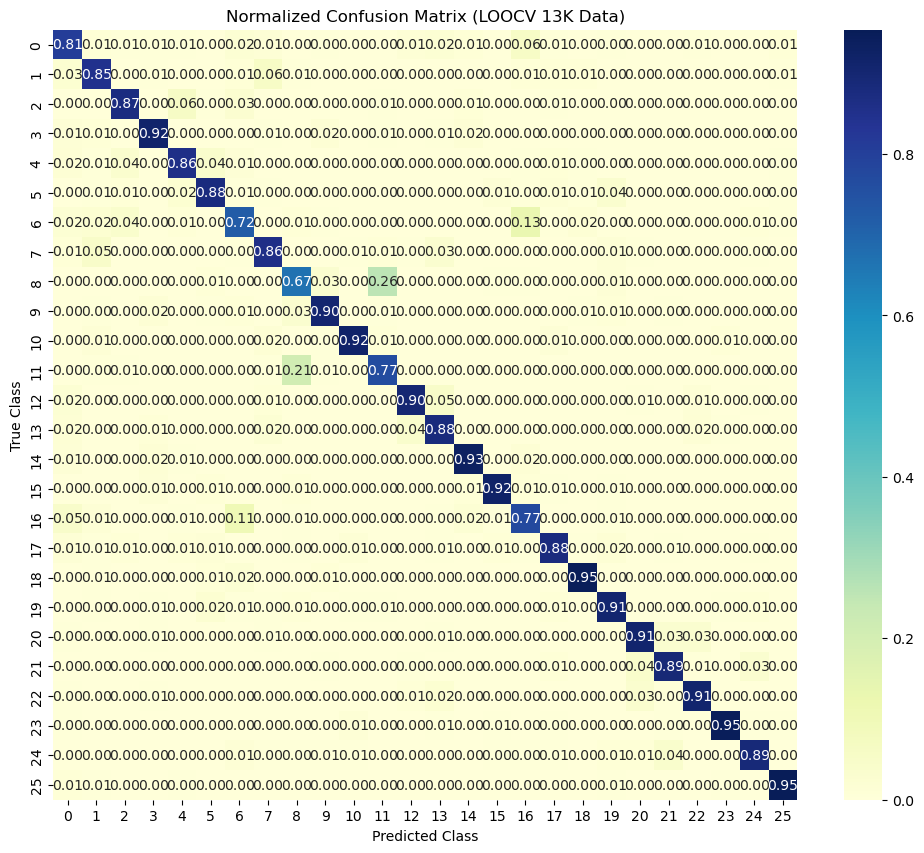

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluasi model
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Akurasi LOOCV: {acc:.4f}")
print(f"Precision rata-rata: {prec:.4f}")
print(f"F1-score rata-rata: {f1:.4f}")

# Confusion matrix normalisasi
cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Normalized Confusion Matrix (LOOCV 13K Data)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

